In [1]:
# utility
import sys
sys.path.append("..")

import utility

# imports
import numpy as np
import json

# modelling
from sklearn import svm
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

# Tree Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import os

In [2]:
# function to load and preprocess quickdraw data
def load_quickdraw_data(dir, category_name, n_samples=1000):
    file = f'full_numpy_bitmap_{category_name}.npy'
    data = np.load(dir + file)
    if n_samples == -1:
        return data
    else:
        indices = np.random.choice(len(data), n_samples, replace=False)
        sampled_data = data[indices]
        return sampled_data

In [3]:
def data_generator(data, batch_size=512):
    n_samples = len(data)
    for i in range(0, n_samples, batch_size):
        batch = data[i:i + batch_size]
        yield batch

In [4]:
files = os.listdir(r'..\data\\')
categories = [file.split('_')[-1].split('.')[0] for file in files]

In [5]:
# Directory where data files are stored
dir = '../data/'

# Load and preprocess data
all_data = []
labels = []

In [6]:
for category_name in categories:
    category_data = load_quickdraw_data(dir, category_name, 1000) # Change this to -1 for all data
    all_data.extend(category_data)
    labels.extend([category_name] * len(category_data))

In [7]:
# split the data into training and test
x_train, x_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.2, random_state=42)

In [8]:
print(len(all_data))

345000


In [9]:
# normalize data
x_train = np.array(x_train).astype(np.float32) / 255
x_test = np.array(x_test).astype(np.float32) / 255

In [10]:
# Add Outliers
num_outliers = 500

# Generate random outliers
outliers = np.random.rand(num_outliers, 784)

In [11]:
# Append outliers to your training data
x_train_with_outliers = np.vstack((x_train, outliers))

# Create labels for the outliers (e.g., label them as "outlier" or use a different category)
y_train_with_outliers = y_train + ['outlier'] * num_outliers

In [12]:
# Perform PCA for dimensionality reduction
n_components = 20  # You can choose the number of components
pca = PCA(n_components=n_components)

In [13]:
x_train_pca = None
# Perform PCA on x_train_with_outliers using a generator
for batch in data_generator(x_train_with_outliers):
    batch_pca = pca.fit_transform(batch)
    if x_train_pca is None:
        x_train_pca = batch_pca
    else:
        x_train_pca = np.vstack((x_train_pca, batch_pca))

In [14]:
x_test_pca = None
# Perform PCA on x_train_with_outliers using a generator
for batch in data_generator(x_test):
    batch_pca = pca.transform(batch)
    if x_test_pca is None:
        x_test_pca = batch_pca
    else:
        x_test_pca = np.vstack((x_test_pca, batch_pca))

In [15]:
# Train an One-Class SVM
model = svm.OneClassSVM(nu=0.1, kernel="rbf")  # Adjust parameters as needed
model.fit(x_train_pca)  # Use the reduced-dimensionality data

OneClassSVM(nu=0.1)

In [16]:
y_pred_train = model.predict(x_train_pca)

In [17]:
# Evaluate the model
y_train_true = [1 if label == 'outlier' else -1 for label in y_train]  # Convert labels for evaluation
print("Precision:", precision_score(y_train_true, y_train_true))
print("Recall:", recall_score(y_train_true, y_train_true))
print("F1-Score:", f1_score(y_train_true, y_train_true))
print("Classification Report:\n", classification_report(y_train_true, y_train_true))

c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0


c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1-Score: 0.0
Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00    276000

    accuracy                           1.00    276000
   macro avg       1.00      1.00      1.00    276000
weighted avg       1.00      1.00      1.00    276000



In [18]:
# Predict anomalies on the test data
y_pred = model.predict(x_test_pca)

In [19]:
# Evaluate the model
y_true = [1 if label == 'outlier' else -1 for label in y_test]  # Convert labels for evaluation
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-Score:", f1_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00   69000.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00   69000.0
   macro avg       0.00      0.00      0.00   69000.0
weighted avg       0.00      0.00      0.00   69000.0



c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: 

In [20]:
# Visualize the decision boundary (2D case)
if n_components == 2:
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
    plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_pred, cmap=plt.cm.Paired)
    plt.title("SVM Anomaly Detection")
    plt.show()

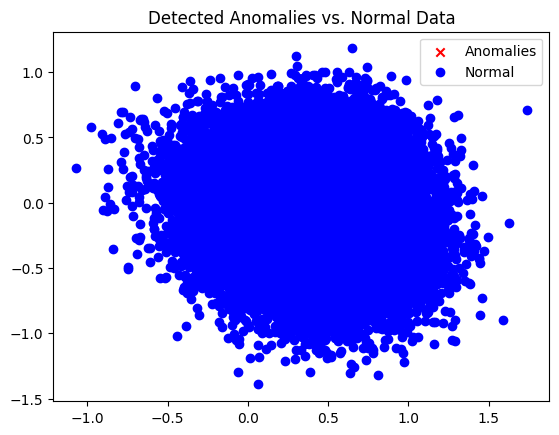

In [21]:
# Visualize detected anomalies separately
anomalies = x_test_pca[y_pred == -1]
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red', marker='x', label='Anomalies')
plt.scatter(x_test_pca[y_pred == 1][:, 0], x_test_pca[y_pred == 1][:, 1], c='blue', marker='o', label='Normal')
plt.legend()
plt.title("Detected Anomalies vs. Normal Data")
plt.show()

In [22]:
# Feature importance analysis
explained_variance = pca.explained_variance_ratio_
print("Explained Variance of Principal Components:")
print(explained_variance)

Explained Variance of Principal Components:
[6.86230550e-02 6.45096434e-02 6.40554732e-02 6.20821507e-02
 5.92322117e-02 5.75779274e-02 5.60258557e-02 5.50977888e-02
 5.43267259e-02 5.27991460e-02 5.02384559e-02 5.00434511e-02
 4.90296760e-02 4.57155885e-02 4.49701110e-02 4.28963423e-02
 4.19718901e-02 4.13257365e-02 3.94787708e-02 5.31522959e-32]


In [23]:
# Adjust the threshold (e.g., make it more stringent)
threshold = -0.2
y_pred_adjusted = [1 if score >= threshold else -1 for score in model.decision_function(x_test_pca)]

In [24]:
# Calculate performance metrics for anomalies
anomalies_true = [1 if label == 'outlier' else -1 for label in y_test]
anomalies_precision = precision_score(anomalies_true, y_pred_adjusted)
anomalies_recall = recall_score(anomalies_true, y_pred_adjusted)
anomalies_f1_score = f1_score(anomalies_true, y_pred_adjusted)
print("Anomalies Precision:", anomalies_precision)
print("Anomalies Recall:", anomalies_recall)
print("Anomalies F1-Score:", anomalies_f1_score)

Anomalies Precision: 0.0
Anomalies Recall: 0.0
Anomalies F1-Score: 0.0


c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Error analysis
false_positive_indices = [i for i, (true, pred) in enumerate(zip(anomalies_true, y_pred_adjusted)) if true == -1 and pred == 1]
false_negative_indices = [i for i, (true, pred) in enumerate(zip(anomalies_true, y_pred_adjusted)) if true == 1 and pred == -1]

print("False Positives:")
for idx in false_positive_indices:
    print(f"Index {idx}, Actual: {anomalies_true[idx]}, Predicted: {y_pred_adjusted[idx]}")

print("False Negatives:")
for idx in false_negative_indices:
    print(f"Index {idx}, Actual: {anomalies_true[idx]}, Predicted: {y_pred_adjusted[idx]}")

False Positives:
Index 0, Actual: -1, Predicted: 1
Index 1, Actual: -1, Predicted: 1
Index 2, Actual: -1, Predicted: 1
Index 3, Actual: -1, Predicted: 1
Index 4, Actual: -1, Predicted: 1
Index 5, Actual: -1, Predicted: 1
Index 6, Actual: -1, Predicted: 1
Index 7, Actual: -1, Predicted: 1
Index 8, Actual: -1, Predicted: 1
Index 9, Actual: -1, Predicted: 1
Index 10, Actual: -1, Predicted: 1
Index 11, Actual: -1, Predicted: 1
Index 12, Actual: -1, Predicted: 1
Index 13, Actual: -1, Predicted: 1
Index 14, Actual: -1, Predicted: 1
Index 15, Actual: -1, Predicted: 1
Index 16, Actual: -1, Predicted: 1
Index 17, Actual: -1, Predicted: 1
Index 18, Actual: -1, Predicted: 1
Index 19, Actual: -1, Predicted: 1
Index 20, Actual: -1, Predicted: 1
Index 21, Actual: -1, Predicted: 1
Index 22, Actual: -1, Predicted: 1
Index 23, Actual: -1, Predicted: 1
Index 24, Actual: -1, Predicted: 1
Index 25, Actual: -1, Predicted: 1
Index 26, Actual: -1, Predicted: 1
Index 27, Actual: -1, Predicted: 1
Index 28, Act